In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
from sklearn.metrics import jaccard_score
from PIL import Image
import numpy as np
import random
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
from glob import glob

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 15
BATCH_SIZE = 4
LEARNING_RATE = 0.001
DATA_DIR = 'PH2Dataset\\PH2_Dataset'

In [16]:
class PH2Dataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = img_path.replace('_Dermoscopic_Image', '_lesion').replace('.bmp', '_lesion.bmp')

        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"))

        # Бинаризация маски
        _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        mask = mask / 255.0  # нормализуем до [0, 1]

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']

        return image, mask.unsqueeze(0)  # добавляем канал

In [ ]:
transform_train = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.2),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.2),
    A.CLAHE(p=0.5),
    A.GridDistortion(p=0.5),
    A.Normalize(mean=[0.0], std=[1.0]),
    ToTensorV2()
])

c:\Users\alexysxeightn\AppData\Local\Programs\Python\Python312\Lib\site-packages\albumentations\core\validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [7]:
class DoubleConv(nn.Module):
    # Блок из двух сверток для U-Net
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Блоки, идущие вниз
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Блоки, идущие вверх
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        # Горлышко посередине
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [8]:
def calculate_iou(preds, targets):
    preds = (preds.sigmoid() > 0.5).cpu().numpy().flatten()
    targets = targets.cpu().numpy().flatten()
    return jaccard_score(targets, preds, average='binary')

In [ ]:
def train_model(model, loss_fn, optimizer, scheduler, dataloader, num_epochs=10):
    model.to(DEVICE)

    best_iou = 0.0
    best_model_weights = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_iou = 0.0

        for images, masks in dataloader:
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            loss.backward()
            optimizer.step()

            iou = calculate_iou(outputs, masks)
            running_iou += iou
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(dataloader)
        epoch_iou = running_iou / len(dataloader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, IoU: {epoch_iou:.4f}")

        if epoch_iou > best_iou:
            best_iou = epoch_iou
            best_model_weights = model.state_dict()

        scheduler.step()

    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)
        
    return model

In [22]:
# Сбор путей к изображениям и маскам
image_paths = []
mask_paths = []

for root, dirs, files in os.walk(DATA_DIR):
    if root.endswith('_Dermoscopic_Image'):
        image_paths.append(os.path.join(root, files[0]))
    elif root.endswith('_lesion'):
        mask_paths.append(os.path.join(root, files[0]))

# Деление на train/val/test
random.shuffle(image_paths)
split_idx = int(0.8 * len(image_paths))
train_paths, val_paths = image_paths[:split_idx], image_paths[split_idx:]

# Создание датасетов и загрузчиков
train_dataset = PH2Dataset(train_paths, transform=transform_train)
val_dataset = PH2Dataset(val_paths, transform=transform_train)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


model = UNET()
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

print("Обучение начато...")
model = train_model(model, loss_fn, optimizer, scheduler, train_loader, num_epochs=EPOCHS)
print("Обучение завершено.")

Обучение начато...
Epoch 1/15, Loss: 1.7477, IoU: 0.5926
Epoch 2/15, Loss: 1.3353, IoU: 0.6697
Epoch 3/15, Loss: 1.2205, IoU: 0.6849
Epoch 4/15, Loss: 1.1436, IoU: 0.6965
Epoch 5/15, Loss: 1.1758, IoU: 0.7000
Epoch 6/15, Loss: 1.0356, IoU: 0.7218
Epoch 7/15, Loss: 0.9423, IoU: 0.7426
Epoch 8/15, Loss: 1.0138, IoU: 0.7275
Epoch 9/15, Loss: 0.9861, IoU: 0.7233
Epoch 10/15, Loss: 1.0006, IoU: 0.7371
Epoch 11/15, Loss: 0.9730, IoU: 0.7385
Epoch 12/15, Loss: 0.9325, IoU: 0.7393
Epoch 13/15, Loss: 0.9174, IoU: 0.7435
Epoch 14/15, Loss: 0.8524, IoU: 0.7653
Epoch 15/15, Loss: 0.8364, IoU: 0.7755
Обучение завершено.


In [24]:
# Сохранение модели
def save_model(model, path='unet.pth'):
    torch.save(model.state_dict(), path)
    print(f"Модель сохранена в {path}")

save_model(model)

Модель сохранена в unet.pth


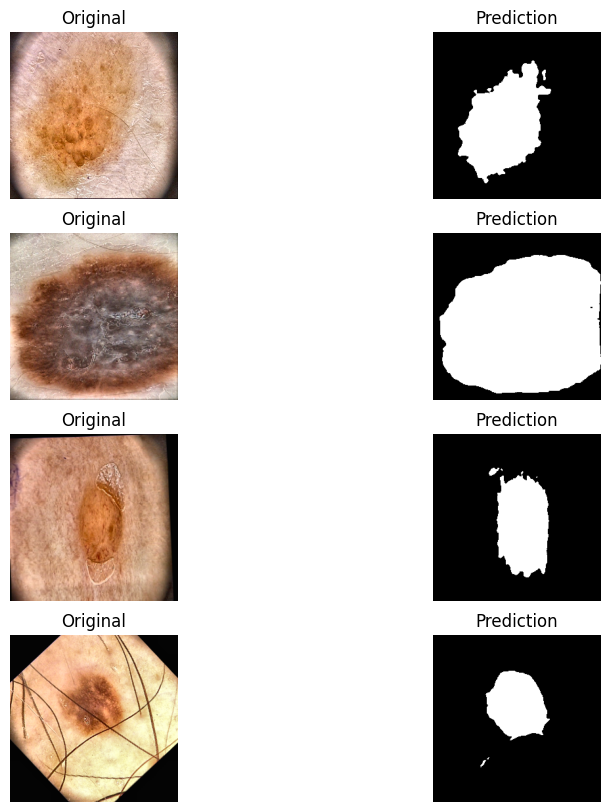

In [25]:
model.eval()
with torch.no_grad():
    images, masks = next(iter(val_loader))
    images = images.to(DEVICE)
    outputs = model(images)
    preds = (torch.sigmoid(outputs) > 0.5).squeeze().cpu().numpy()

plt.figure(figsize=(10, 10))
for i in range(len(images)):
    plt.subplot(len(images), 2, i*2+1)
    plt.imshow(transforms.ToPILImage()(images[i].cpu()))
    plt.title("Original")
    plt.axis("off")

    plt.subplot(len(images), 2, i*2+2)
    plt.imshow(preds[i], cmap="gray")
    plt.title("Prediction")
    plt.axis("off")
plt.show()